In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows=6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [3]:
set.seed(209)
#reading the dataset from the URL
heart_disease_data <- read_csv("https://raw.githubusercontent.com/QiXu2022/dsci-100-project-Group_66/main/heart_disease_uci.csv")
heart_disease_data <- mutate(heart_disease_data, restecg = as_factor(restecg))

Rows: 920 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): sex, dataset, cp, restecg, slope, thal
dbl (8): id, age, trestbps, chol, thalch, oldpeak, ca, num
lgl (2): fbs, exang

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
#tidying the data
tidy_data<-heart_disease_data |>
    filter(dataset=="Cleveland") |>
    select(age, trestbps, chol, restecg) 
tidy_data

age,trestbps,chol,restecg
<dbl>,<dbl>,<dbl>,<fct>
63,145,233,lv hypertrophy
67,160,286,lv hypertrophy
67,120,229,lv hypertrophy
⋮,⋮,⋮,⋮
57,130,236,lv hypertrophy
38,138,175,normal
28,130,132,lv hypertrophy


In [5]:
heart_split<- initial_split(tidy_data, prop=0.75, strata=restecg)
heart_train<- training(heart_split)
heart_test<-testing(heart_split)

#### Firstly, we build model of using age, trestbps and chol to predict restecg by k-nn classification.


! Fold2: internal:
  No observations were detected in `truth` for level(s): 'st-t abnormality'
  Computation will proceed by ignoring those levels.

! Fold3: internal:
  No observations were detected in `truth` for level(s): 'st-t abnormality'
  Computation will proceed by ignoring those levels.



neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.5189152,5,0.05332505,Preprocessor1_Model01
3,accuracy,multiclass,0.5592139,5,0.06299349,Preprocessor1_Model02
5,accuracy,multiclass,0.5634739,5,0.04497834,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
12,accuracy,multiclass,0.5804743,5,0.04933744,Preprocessor1_Model10
13,accuracy,multiclass,0.5937154,5,0.04329671,Preprocessor1_Model11
14,accuracy,multiclass,0.6069565,5,0.03831518,Preprocessor1_Model12


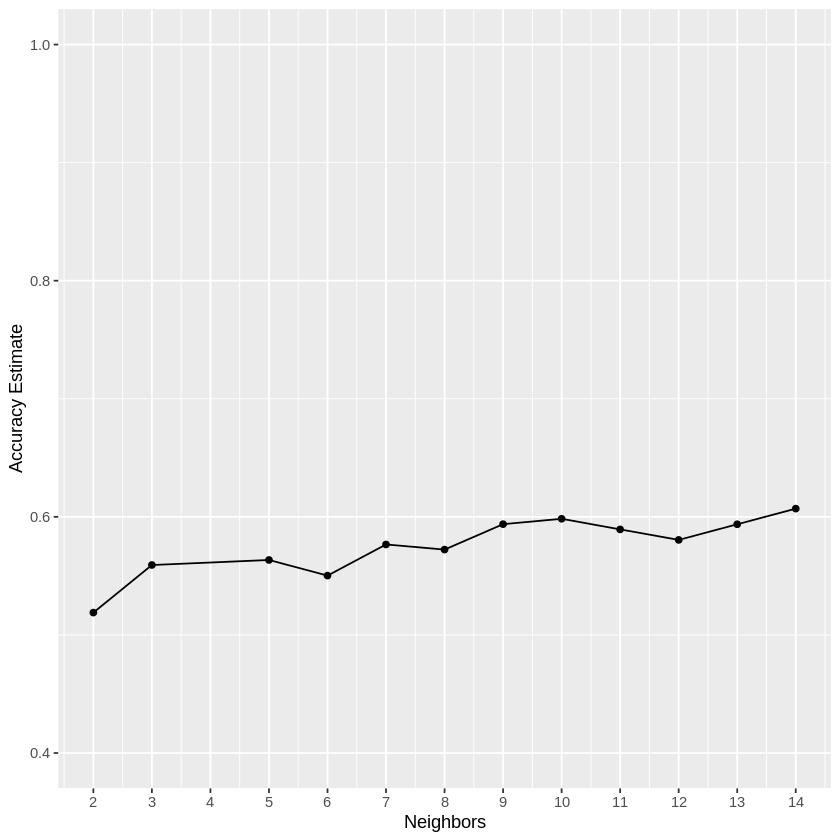

In [32]:
set.seed(2020)
## 5-fold cross validation
heart_recipe = recipe(restecg ~ ., data = heart_train) |>
                step_center(all_predictors()) |>
                step_scale(all_predictors())
heart_spec = nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")
heart_vf <- vfold_cv(heart_train, v = 5, strata = restecg)

heart_results = workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_spec)|>
    tune_grid(resamples = heart_vf, grid = 15) |>
    collect_metrics()

heart_accuracies <- heart_results |> 
       filter(.metric == "accuracy", .estimator == "multiclass")

heart_accuracies

heart_accuracy_plot <- ggplot(heart_accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(1, 16, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.4, 1)) # adjusting the y-axis

heart_accuracy_plot

According to the plot above, we choose k = 14.

In [10]:
heart_retrain_spec = nearest_neighbor(weight_func = "rectangular", neighbors = 14) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_fit = workflow() |>
       add_recipe(heart_recipe) |>
       add_model(heart_retrain_spec) |>
       fit(data = heart_train)

heart_predictions <- predict(heart_fit , heart_test) |>
                    bind_cols(heart_test)
heart_predictions

heart_metrics <- heart_predictions |>
         metrics(truth = restecg, estimate = .pred_class)
heart_metrics

heart_conf_mat <- heart_predictions |> 
       conf_mat(truth = restecg, estimate = .pred_class)
heart_conf_mat





.pred_class,age,trestbps,chol,restecg
<fct>,<dbl>,<dbl>,<dbl>,<fct>
lv hypertrophy,37,130,250,normal
normal,56,120,236,normal
normal,53,140,203,lv hypertrophy
⋮,⋮,⋮,⋮,⋮
lv hypertrophy,45,110,264,normal
lv hypertrophy,57,130,131,normal
normal,28,130,132,lv hypertrophy


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.4285714
kap,multiclass,-0.1285809


                  Truth
Prediction         lv hypertrophy normal st-t abnormality
  lv hypertrophy               16     22                0
  normal                       21     17                1
  st-t abnormality              0      0                0

#### let's do the second model using age, trestbps to predict restecg by k-nn classification.

! Fold2: internal:
  No observations were detected in `truth` for level(s): 'st-t abnormality'
  Computation will proceed by ignoring those levels.

! Fold3: internal:
  No observations were detected in `truth` for level(s): 'st-t abnormality'
  Computation will proceed by ignoring those levels.



neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.4802855,5,0.03196545,Preprocessor1_Model01
3,accuracy,multiclass,0.4844357,5,0.04239692,Preprocessor1_Model02
5,accuracy,multiclass,0.5326570,5,0.05279921,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
12,accuracy,multiclass,0.5282082,5,0.05347684,Preprocessor1_Model10
13,accuracy,multiclass,0.5367984,5,0.04804056,Preprocessor1_Model11
14,accuracy,multiclass,0.5413439,5,0.04467043,Preprocessor1_Model12


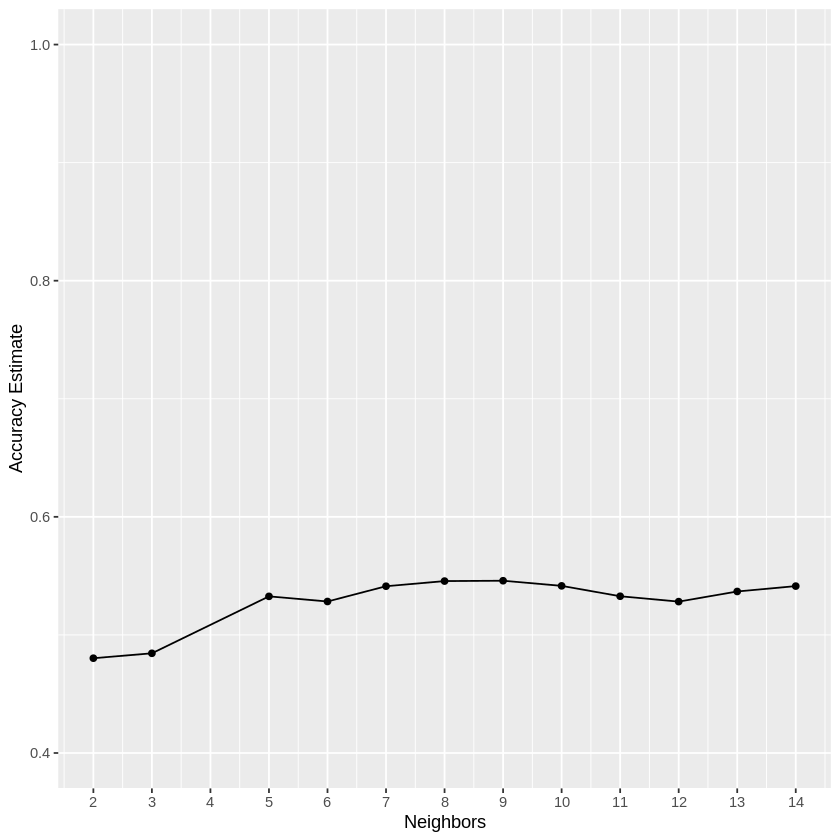

In [33]:
set.seed(2020)
## 5-fold cross validation
heart_recipe = recipe(restecg ~ age + trestbps, data = heart_train) |>
                step_center(all_predictors()) |>
                step_scale(all_predictors())
heart_spec = nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")
heart_vf <- vfold_cv(heart_train, v = 5, strata = restecg)

heart_results = workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_spec)|>
    tune_grid(resamples = heart_vf, grid = 15) |>
    collect_metrics()

heart_accuracies <- heart_results |> 
       filter(.metric == "accuracy", .estimator == "multiclass")

heart_accuracies

heart_accuracy_plot <- ggplot(heart_accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(1, 16, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.4, 1)) # adjusting the y-axis

heart_accuracy_plot

According to the plot above, we choose k = 9

In [22]:
heart_retrain_spec = nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_fit = workflow() |>
       add_recipe(heart_recipe) |>
       add_model(heart_retrain_spec) |>
       fit(data = heart_train)

heart_predictions <- predict(heart_fit , heart_test) |>
                    bind_cols(heart_test)
heart_predictions

heart_metrics <- heart_predictions |>
         metrics(truth = restecg, estimate = .pred_class)
heart_metrics

heart_conf_mat <- heart_predictions |> 
       conf_mat(truth = restecg, estimate = .pred_class)
heart_conf_mat


.pred_class,age,trestbps,chol,restecg
<fct>,<dbl>,<dbl>,<dbl>,<fct>
normal,37,130,250,normal
normal,56,120,236,normal
lv hypertrophy,53,140,203,lv hypertrophy
⋮,⋮,⋮,⋮,⋮
normal,45,110,264,normal
lv hypertrophy,57,130,131,normal
normal,28,130,132,lv hypertrophy


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5584416
kap,multiclass,0.1308101


                  Truth
Prediction         lv hypertrophy normal st-t abnormality
  lv hypertrophy               23     19                1
  normal                       14     20                0
  st-t abnormality              0      0                0

#### let's do the third model using age, chol to predict restecg by k-nn classification.

! Fold2: internal:
  No observations were detected in `truth` for level(s): 'st-t abnormality'
  Computation will proceed by ignoring those levels.

! Fold3: internal:
  No observations were detected in `truth` for level(s): 'st-t abnormality'
  Computation will proceed by ignoring those levels.



neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.5859157,5,0.02205166,Preprocessor1_Model01
3,accuracy,multiclass,0.5851164,5,0.03404531,Preprocessor1_Model02
5,accuracy,multiclass,0.6112121,5,0.04601030,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
12,accuracy,multiclass,0.6070575,5,0.03173941,Preprocessor1_Model10
13,accuracy,multiclass,0.5846245,5,0.04271895,Preprocessor1_Model11
14,accuracy,multiclass,0.5846245,5,0.04271895,Preprocessor1_Model12


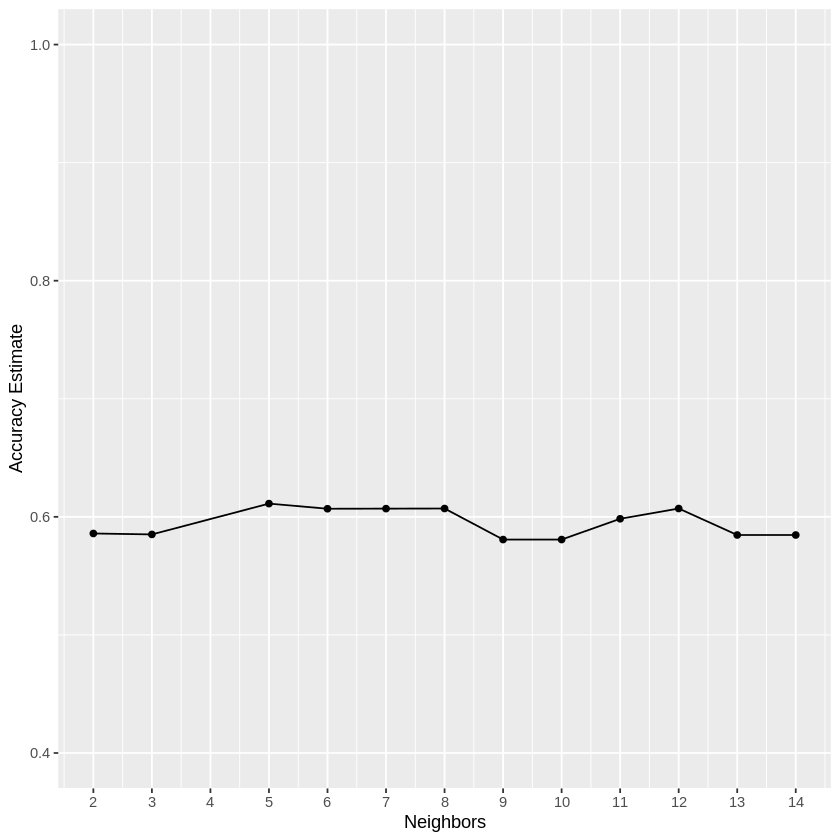

In [34]:
set.seed(2020)
## 5-fold cross validation
heart_recipe = recipe(restecg ~ age + chol, data = heart_train) |>
                step_center(all_predictors()) |>
                step_scale(all_predictors())

heart_spec = nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")
heart_vf <- vfold_cv(heart_train, v = 5, strata = restecg)

heart_results = workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_spec)|>
    tune_grid(resamples = heart_vf, grid = 15) |>
    collect_metrics()

heart_accuracies <- heart_results |> 
       filter(.metric == "accuracy", .estimator == "multiclass")

heart_accuracies

heart_accuracy_plot <- ggplot(heart_accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(1, 16, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.4, 1)) # adjusting the y-axis

heart_accuracy_plot

According to the plot above, we choose k = 5.

In [24]:
heart_retrain_spec = nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_fit = workflow() |>
       add_recipe(heart_recipe) |>
       add_model(heart_retrain_spec) |>
       fit(data = heart_train)

heart_predictions <- predict(heart_fit , heart_test) |>
                    bind_cols(heart_test)
heart_predictions

heart_metrics <- heart_predictions |>
         metrics(truth = restecg, estimate = .pred_class)
heart_metrics

heart_conf_mat <- heart_predictions |> 
       conf_mat(truth = restecg, estimate = .pred_class)
heart_conf_mat

.pred_class,age,trestbps,chol,restecg
<fct>,<dbl>,<dbl>,<dbl>,<fct>
normal,37,130,250,normal
lv hypertrophy,56,120,236,normal
normal,53,140,203,lv hypertrophy
⋮,⋮,⋮,⋮,⋮
lv hypertrophy,45,110,264,normal
lv hypertrophy,57,130,131,normal
normal,28,130,132,lv hypertrophy


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.48051948
kap,multiclass,-0.02872411


                  Truth
Prediction         lv hypertrophy normal st-t abnormality
  lv hypertrophy               16     18                0
  normal                       21     21                1
  st-t abnormality              0      0                0

#### Then the final model using trestbps, chol to predict restecg by k-nn classification.

! Fold2: internal:
  No observations were detected in `truth` for level(s): 'st-t abnormality'
  Computation will proceed by ignoring those levels.

! Fold3: internal:
  No observations were detected in `truth` for level(s): 'st-t abnormality'
  Computation will proceed by ignoring those levels.



neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.5631796,5,0.03178283,Preprocessor1_Model01
3,accuracy,multiclass,0.5456873,5,0.03793508,Preprocessor1_Model02
5,accuracy,multiclass,0.5406500,5,0.04598067,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
12,accuracy,multiclass,0.5764207,5,0.03824907,Preprocessor1_Model10
13,accuracy,multiclass,0.5718753,5,0.03712380,Preprocessor1_Model11
14,accuracy,multiclass,0.5806675,5,0.03817487,Preprocessor1_Model12


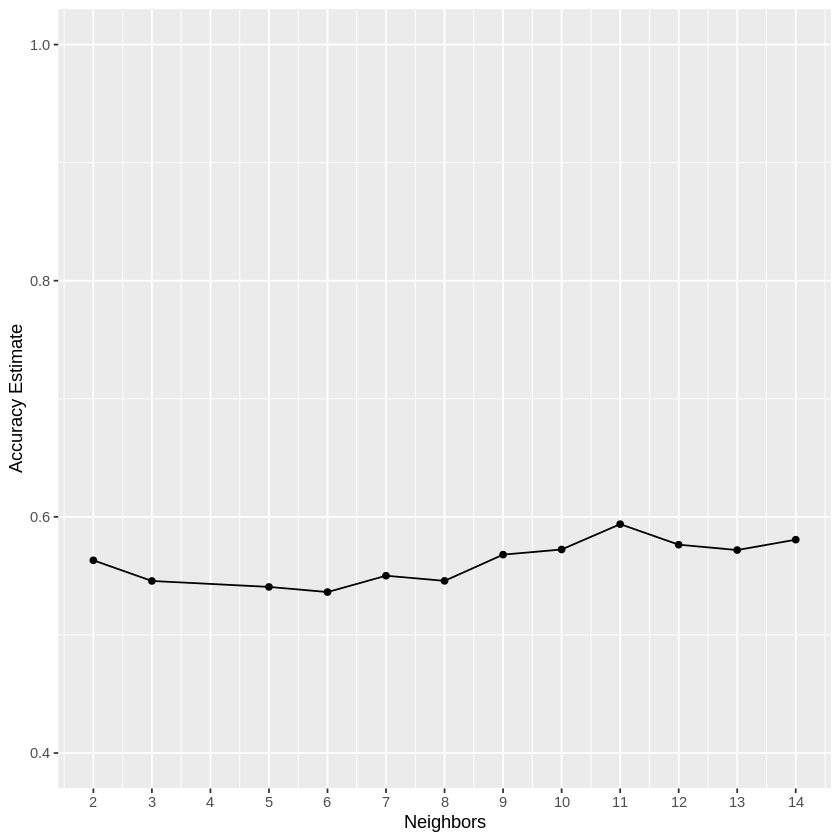

In [35]:
set.seed(2020)
## 5-fold cross validation
heart_recipe = recipe(restecg ~ trestbps + chol, data = heart_train) |>
                step_center(all_predictors()) |>
                step_scale(all_predictors())

heart_spec = nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")
heart_vf <- vfold_cv(heart_train, v = 5, strata = restecg)

heart_results = workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_spec)|>
    tune_grid(resamples = heart_vf, grid = 15) |>
    collect_metrics()

heart_accuracies <- heart_results |> 
       filter(.metric == "accuracy", .estimator == "multiclass")

heart_accuracies

heart_accuracy_plot <- ggplot(heart_accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(1, 16, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.4, 1)) # adjusting the y-axis

heart_accuracy_plot

According to the plot above, we choose k = 11.

In [37]:
heart_retrain_spec = nearest_neighbor(weight_func = "rectangular", neighbors = 11) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_fit = workflow() |>
       add_recipe(heart_recipe) |>
       add_model(heart_retrain_spec) |>
       fit(data = heart_train)

heart_predictions <- predict(heart_fit , heart_test) |>
                    bind_cols(heart_test)
heart_predictions

heart_metrics <- heart_predictions |>
         metrics(truth = restecg, estimate = .pred_class)
heart_metrics

heart_conf_mat <- heart_predictions |> 
       conf_mat(truth = restecg, estimate = .pred_class)
heart_conf_mat

.pred_class,age,trestbps,chol,restecg
<fct>,<dbl>,<dbl>,<dbl>,<fct>
lv hypertrophy,37,130,250,normal
normal,56,120,236,normal
normal,53,140,203,lv hypertrophy
⋮,⋮,⋮,⋮,⋮
lv hypertrophy,45,110,264,normal
normal,57,130,131,normal
normal,28,130,132,lv hypertrophy


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.4935064935
kap,multiclass,-0.0003331113


                  Truth
Prediction         lv hypertrophy normal st-t abnormality
  lv hypertrophy               18     19                1
  normal                       19     20                0
  st-t abnormality              0      0                0

#### Compare the accuracy rate of the four models (0.4285714, 0.5584416, 0.48051948, 0.4935064935), we found the model of using age, trestbps to predict restecg has the highest accuracy. We think this model is the best model to predict restecg.

### Discussion:

We found that Age and trestbps are two factors which are the most associated with heart disease.